In [ ]:
cd "C:/Users/Manip2/SCRIPTS/Code python audrey/code python aurelie/interfaceJupyter/minian"

In [ ]:
import quantities as pq
import numpy as np
import math 
import neo
import json
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy.interpolate import interp2d
import pickle
import os
from scipy.interpolate import griddata
from ast import literal_eval

%matplotlib widget

from itertools import groupby
from ephyviewer import mkQApp, MainViewer, TraceViewer
from IPython.display import display
from ipyfilechooser import FileChooser
from scipy.signal import find_peaks

from minian.utilities import (
    TaskAnnotation,
    get_optimal_chk,
    load_videos,
    open_minian,
    save_minian,
)

In [ ]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    #dpath = "/Users/mb/Documents/Syntuitio/AudreyHay/PlanB/ExampleRedLines/2022_08_06/13_30_01/My_V4_Miniscope/"
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Folder with videos</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

In [ ]:
lfpdisplay=1 # 1 == raw LFP dowloaded / 0 == raw LFP not downloaded

In [ ]:
def readfile(file):
  with open(file, encoding="utf-8") as file:
    list = []
    for row in file:
      temp = row.split()
      list.append(temp[:])
    return list

In [62]:
folder_base = Path(dpath)

nb_sessions = sum(1 for p in folder_base.iterdir() if p.is_dir() and p.name.startswith("session"))
try:
    mfile = open(folder_base / f'mappingsAB.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappingsAB.pkl opened')
except:
    mfile = open(folder_base / f'mappings.pkl', 'rb')
    mapping = pickle.load(mfile)
    print('mappings.pkl opened')

sessions = []
subsessions = []
nb_minian_total=0
dict_Calcium = {}
dict_Spike = {}
dict_SWRprop = {}
dict_Spindleprop = {}
dict_Stamps = {}
dict_StampsMiniscope = {}
dict_TodropFile = {}
dict_RawLFP_CA1 = {}
dict_RawLFP_PFC = {}
dict_Channels = {}
dict_RawLFP_S1 = {}
dict_Scoring = {}
dict_EMG={}
dict_SpindleS1prop={}
for y in range(1, nb_sessions+1):
    session= 'session' + str(y)
    print(session)
    sessions.append(session)
    folder_mini = folder_base / f'session{y}/V4_Miniscope'
    nb_subsessions = sum(1 for p in folder_mini.iterdir() if p.is_dir() and p.name.startswith("session"))
    SWRproperties = folder_base / f'session{y}/OpenEphys/SWRproperties_AB.csv'
    Spindleproperties_PFC = folder_base / f'session{y}/OpenEphys/Spindlesproperties_PFC_AB.csv'
    Spindleproperties_S1 = folder_base / f'session{y}/OpenEphys/Spindlesproperties_S1_AB.csv'
    StampsFile = folder_base / f'session{y}/SynchroFile.xlsx'
    StampsMiniscopeFile = folder_mini / f'timeStamps.csv'
    RawLFP = folder_base / f'session{y}/OpenEphys/RawDataChannelExtractedDS.npy'
    Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 
    ScoringFile = folder_base / f'session{y}/OpenEphys/ScoredSleep.npy'
    if nb_subsessions!=0:        
        for x in range(1, nb_subsessions+1):            
            subsession= "session"  + str(y) + str(x)
            subsessions.append(subsession)    
            minian_ds = open_minian(folder_mini / subsession / f'minian')      # OR minianAB
            dict_Calcium[subsession] = minian_ds['C'] # calcium traces 
            dict_Spike[subsession] = minian_ds['S'] # estimated spikes
            dict_SWRprop[subsession] = pd.read_csv(SWRproperties)
            dict_Spindleprop[subsession] = pd.read_csv(Spindleproperties_PFC)
            dict_SpindleS1prop[subsession] = pd.read_csv(Spindleproperties_S1)
            dict_StampsMiniscope[subsession] = pd.read_csv(StampsMiniscopeFile)
            dict_Scoring[subsession]  = np.load(ScoringFile)


            dict_Stamps[subsession] = pd.read_excel(StampsFile)  #only the first one as the original timestamps
            list_droppedframes = literal_eval(dict_Stamps[subsession][0][3]) 
            SubsessionRecDur = dict_Calcium[subsession].shape[1]
            if x>1:
                prevsubsession= "session"  + str(y) + str(x-1)
                prevSubsessionRecDur = dict_Calcium[prevsubsession].shape[1]
                prevSubsessionStart =dict_Stamps[prevsubsession][0][0]
                if len(list_droppedframes) > 0:
                    numbdropfr = len(list(item for item in range(len(list_droppedframes)) if list_droppedframes[item] < prevSubsessionRecDur + (prevSubsessionStart*minian_freq) and list_droppedframes[item] > (prevSubsessionStart*minian_freq)))
                else:
                    numbdropfr = 0
                endprevious=prevSubsessionStart + (prevSubsessionRecDur + numbdropfr)/dict_Stamps[subsession][0][2]
                dict_Stamps[subsession][0][0]=endprevious 
            
            if lfpdisplay==1:
                mice = os.path.basename(folder_base)
                allchannels = pd.read_excel(Channels)
                PFCch1=int(allchannels[mice][0].split(',')[0]) #S1 or PFC
                PFCch2=int(allchannels[mice][0].split(',')[1]) #S1 or PFC
                CA1ch1=int(allchannels[mice][2].split(',')[0])
                CA1ch2=int(allchannels[mice][2].split(',')[1])
                S1ch1=int(allchannels[mice][1].split(',')[0])
                S1ch2=int(allchannels[mice][1].split(',')[1])
                EMGch=int(allchannels[mice][3])
                All = np.load(RawLFP, mmap_mode= 'r')
                dict_RawLFP_PFC[subsession]  =  All[:, PFCch1]-All[:, PFCch2] 
                dict_RawLFP_CA1[subsession]  =  All[:, CA1ch1]-All[:, CA1ch2] 
                dict_RawLFP_S1[subsession]  =  All[:, S1ch1]-All[:, S1ch2] 
                dict_EMG[subsession]  =  All[:, EMGch] 
            try:
                TodropFile = folder_mini / subsession / f'minian/TodropFileAB.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            except:
                TodropFile = folder_mini / subsession / f'minian/TodropFile.json'
                with open(TodropFile, 'r') as f:
                    unit_to_drop = json.load(f)
                    dict_TodropFile[subsession]  = unit_to_drop
            nb_minian_total+=1
            print(nb_minian_total)
    else:
        minian_ds = open_minian(folder_mini / f'minian')            # OR minianAB
        dict_Calcium[session] = minian_ds['C'] # calcium traces 
        dict_Spike[session] = minian_ds['S'] # estimated spikes
        dict_SWRprop[session]  = pd.read_csv(SWRproperties)
        dict_Spindleprop[session]  = pd.read_csv(Spindleproperties_PFC)
        dict_Stamps[session]  = pd.read_excel(StampsFile)
        dict_StampsMiniscope[session]  = pd.read_csv(StampsMiniscopeFile)
        dict_Scoring[session]  = np.load(ScoringFile) 
        dict_SpindleS1prop[session] = pd.read_csv(Spindleproperties_S1)


        if lfpdisplay==1:
            mice = os.path.basename(folder_base)
            allchannels = pd.read_excel(Channels)
            PFCch1=int(allchannels[mice][0].split(',')[0])
            PFCch2=int(allchannels[mice][0].split(',')[1])
            CA1ch1=int(allchannels[mice][2].split(',')[0])
            CA1ch2=int(allchannels[mice][2].split(',')[1])
            S1ch1=int(allchannels[mice][1].split(',')[0])
            S1ch2=int(allchannels[mice][1].split(',')[1])
            EMGch=int(allchannels[mice][3])
            All = np.load(RawLFP, mmap_mode= 'r')
            dict_RawLFP_PFC[session]  =  All[:, PFCch1]-All[:, PFCch2] 
            dict_RawLFP_CA1[session]  =  All[:, CA1ch1]-All[:, CA1ch2] 
            dict_RawLFP_S1[session]  =  All[:, S1ch1]-All[:, S1ch2] 
            dict_EMG[session]  =  All[:, EMGch] 

        try:
            TodropFile = folder_mini / f'minian/TodropFileAB.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        except:
            TodropFile = folder_mini / f'minian/TodropFile.json'
            with open(TodropFile, 'r') as f:
                unit_to_drop = json.load(f)
                dict_TodropFile[session]  = unit_to_drop
        nb_minian_total+=1  
        print(nb_minian_total)

mappingsAB.pkl opened
session1


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

1
session2


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

2
session3


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

3
session4


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

4
session5


C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  arr = list(xr.open_zarr(arr_path).values())[0]
C:\Users\Manip2\SCRIPTS\Code python audrey\code python aurelie\interfaceJupyter\minian\minian\utilities.py:342: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, c

5


In [76]:
for i in list(dict_Stamps.keys()):
    
    # Start time & freq miniscope
    StartTime = list(dict_Stamps[i][0])[0] # in seconds
    minian_freq=list(dict_Stamps[i][0])[2] # in Hz
    list_droppedframes = literal_eval(dict_Stamps[i][0][3])

    First_frame = 0 #StartTime*minian_freq 
    C=dict_Calcium[i]
    Cupd = C.loc[:, First_frame:]
    rec_dur = Cupd.shape[1]
    S=dict_Spike[i] 
    Supd = S.loc[:, First_frame:]
    if len(list_droppedframes) > 0:
        numbdropfr = len(list(item for item in range(len(list_droppedframes)) if list_droppedframes[item] < rec_dur + (StartTime*minian_freq) and list_droppedframes[item] > (StartTime*minian_freq)))
    else:
        numbdropfr = 0
    EndTime = StartTime + ((rec_dur + numbdropfr)/minian_freq) # in seconds

    AA = C['unit_id']
    copyAA = list(AA.copy())
    unit_to_drop=dict_TodropFile[i]    
    for u in unit_to_drop:
        copyAA.remove(u)
    unit_to_keep = copyAA
    Cupd = Cupd.loc[unit_to_keep,:]
    Supd = Supd.loc[unit_to_keep,:]
    nb_unit = Cupd.shape[0]
    print('In', i, ', kept values =', Cupd['unit_id'].values)

    if i=='session2':
        StartTimeI = StartTime
        LFPtraceCA1=dict_RawLFP_CA1[i] #-StartTime*1000
        LFPtraceS1=dict_RawLFP_S1[i]# -StartTime*1000
        LFPtracePFC=dict_RawLFP_PFC[i] #-StartTime*1000
        CaTrace = Cupd
        SpTrace = Supd 
        Scor=dict_Scoring[i]    
        EMG=dict_EMG[i]
        PFCspipropO=dict_Spindleprop[i]
        PFCspipropM=PFCspipropO.copy()
        PFCspipropM[["peak time", "start time", "end time"]] = PFCspipropO[["peak time", "start time", "end time"]]-(StartTime*1000)

        S1pipropO=dict_SpindleS1prop[i]
        S1pipropM=S1pipropO.copy()
        S1pipropM[["peak time", "start time", "end time"]] = S1pipropO[["peak time", "start time", "end time"]]-(StartTime*1000)

        SWRpropO=dict_SWRprop[i]
        SWRpropM=SWRpropO.copy()
        SWRpropM[["peak time", "start time", "end time"]] = SWRpropO[["peak time", "start time", "end time"]]-(StartTime*1000)


In session1 , kept values = [ 7  8 13 15 19 20 26 33 36 37 41 47 60 61 62 63]
In session2 , kept values = [ 0  1  3  5  6  7  9 11 12 16 18]
In session3 , kept values = [ 0  4  5  8 14 18]
In session4 , kept values = [ 4  7  8 10]
In session5 , kept values = [  4  17  41  55  89  94  99 107 108]


In [ ]:
"""
from scipy.interpolate import interp1d
vector = np.array(LFPtraceCA1)
new_sampling_points = np.linspace(0, len(vector) - 1, num=int(len(vector)/1000*minian_freq))
interpolator = interp1d(np.arange(len(vector)), vector, kind='nearest')
LFPtraceCA1 = interpolator(new_sampling_points)
vector = np.array(LFPtracePFC)
new_sampling_points = np.linspace(0, len(vector) - 1, num=int(len(vector)/1000*minian_freq))
interpolator = interp1d(np.arange(len(vector)), vector, kind='nearest')
LFPtracePFC = interpolator(new_sampling_points)
vector = np.array(LFPtraceS1)
new_sampling_points = np.linspace(0, len(vector) - 1, num=int(len(vector)/1000*minian_freq))
interpolator = interp1d(np.arange(len(vector)), vector, kind='nearest')
LFPtraceS1 = interpolator(new_sampling_points)
vector = np.array(EMG)
new_sampling_points = np.linspace(0, len(vector) - 1, num=int(len(vector)/1000*minian_freq))
interpolator = interp1d(np.arange(len(vector)), vector, kind='nearest')
EMG = interpolator(new_sampling_points)
"""

In [ ]:
"""
scale_factor=minian_freq/0.2  #cause scoring was done in 5 seconds bin, ie 0.2 Hz
SleepScoredTS=Scor
SleepScoredTS_upscaled = np.repeat(SleepScoredTS, scale_factor, axis=0)
StartTime_frame=int(StartTime*minian_freq)
SleepScoredTS_upscaled_ministart=SleepScoredTS_upscaled[int(StartTime_frame):]
SleepScoredTS_upscaled_ministart
"""


In [77]:
StartTimeI

4.17896

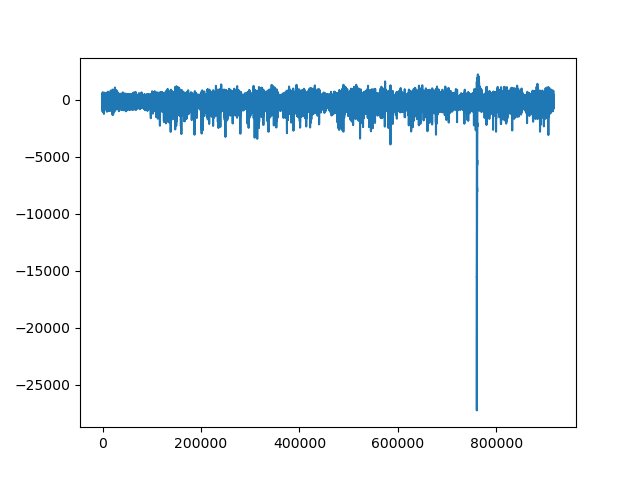

In [67]:
plt.close()
plt.plot(LFPtraceCA1)

In [104]:
PFCspipropM/1000
S1pipropM/1000

,Unnamed: 0,peak time,Duration,peak amp,start time,end time,Max freq,Max int,Avg freq,Avg int
0,0.000,151.09804,0.959,0.154,150.52904,151.48804,0.015,3.683,0.012,0.953
1,0.001,161.84804,0.909,0.178,161.17704,162.08604,0.015,3.326,0.012,0.878
2,0.002,237.85404,3.144,0.172,237.14404,240.28804,0.015,3.872,0.012,0.756
3,0.003,437.28804,0.743,0.143,436.91704,437.66004,0.015,2.942,0.012,0.784
4,0.004,579.25404,1.282,0.144,579.00504,580.28704,0.015,3.153,0.012,0.890
5,0.005,645.58604,0.892,0.192,645.31104,646.20304,0.015,3.169,0.012,0.817
6,0.006,652.13604,0.749,0.182,651.65304,652.40204,0.015,2.990,0.012,0.783
7,0.007,653.50004,0.502,0.249,653.30504,653.80704,0.015,2.901,0.012,0.886
8,0.008,670.31304,3.073,0.152,668.23104,671.30404,0.015,3.280,0.012,0.694
9,0.009,816.15204,1.009,0.164,815.47004,816.47904,0.015,3.746,0.012,0.917


In [72]:
SWRpropM/1000

,Unnamed: 0,peak time,Duration,peak amp,start time,end time,Max freq,Max int,Avg freq,Avg int
0,0.000,93.91304,0.046,0.141,93.88604,93.93204,0.199,0.660,0.151,0.278
1,0.001,112.37904,0.038,0.140,112.36004,112.39904,0.191,0.591,0.155,0.259
2,0.002,121.75504,0.042,0.185,121.73304,121.77504,0.196,0.824,0.151,0.372
3,0.003,125.87304,0.050,0.169,125.85104,125.90104,0.199,0.802,0.148,0.326
4,0.004,132.12104,0.054,0.145,132.09904,132.15304,0.199,0.649,0.148,0.262
...,...,...,...,...,...,...,...,...,...,...
148,0.148,891.79704,0.044,0.154,891.77604,891.82004,0.199,0.730,0.148,0.305
149,0.149,892.42604,0.047,0.170,892.39804,892.44504,0.196,0.783,0.152,0.318
150,0.150,894.65804,0.052,0.200,894.63404,894.68704,0.199,1.048,0.155,0.398
151,0.151,901.50304,0.041,0.159,901.48204,901.52304,0.196,0.680,0.154,0.288


<function matplotlib.pyplot.show(block=None)>

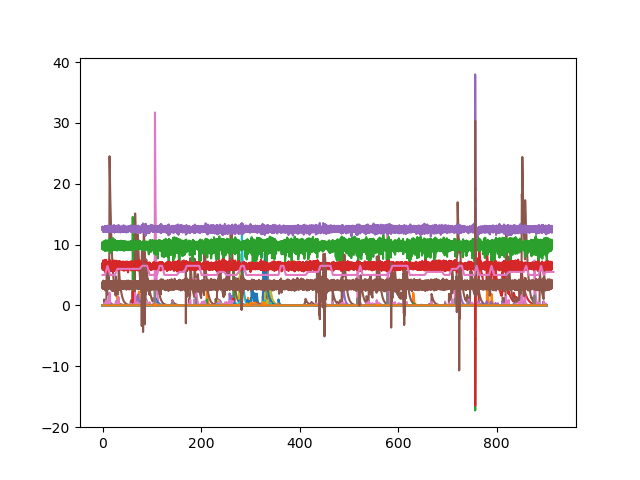

In [84]:
plt.close()
x=np.linspace(0, len(CaTrace.T)/minian_freq, len(CaTrace.T))
plt.plot(x, CaTrace.T)
plt.plot(x, SpTrace.T)
x=np.linspace(0,  len(LFPtraceCA1[int(StartTimeI*1000):])/1000, len(LFPtraceCA1[int(StartTimeI*1000):]))
plt.plot(x, LFPtraceCA1[int(StartTimeI*1000):] /1000 +10)
plt.plot(x, LFPtraceS1[int(StartTimeI*1000):]/1000 +7)
plt.plot(x, LFPtracePFC[int(StartTimeI*1000):]/1000 +13)
plt.plot(x, EMG[int(StartTimeI*1000):]/1000 +3)
x=np.linspace(0, len(Scor[int(StartTimeI*0.2):])/0.2, len(Scor[int(StartTimeI*0.2):]))
plt.plot(x, Scor[int(StartTimeI*0.2):] +5)
plt.show

In [80]:
file_path = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/RawTracesPlotFinal_RedLinesOKsession2-test.emf'

# Save the plot as an EMF file
plt.savefig(file_path, format='eps')

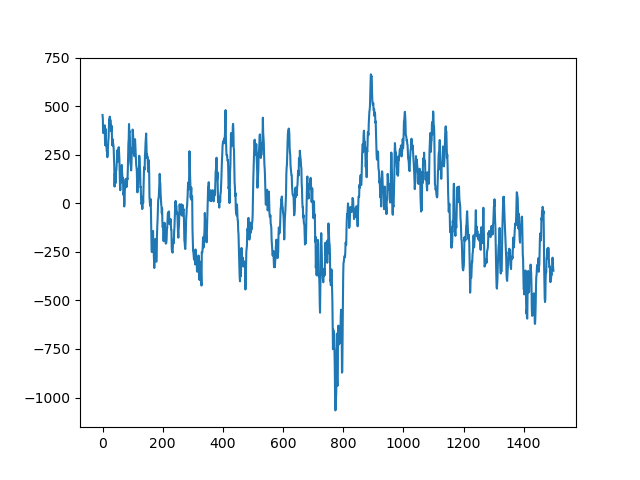

In [94]:
file_path = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/RawTracesPlotFinal_RedLinesOKsession2-test2.eps'# Save the plot as an EMF file
plt.savefig(file_path, format='eps')

In [118]:
from scipy import signal

# Filtre parameter:
f_lowcut = 120.
f_hicut = 200.
fs = 1000
nyq = 0.5 * fs
N = 6                 # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_CA1 = signal.filtfilt(b, a, LFPtraceCA1)

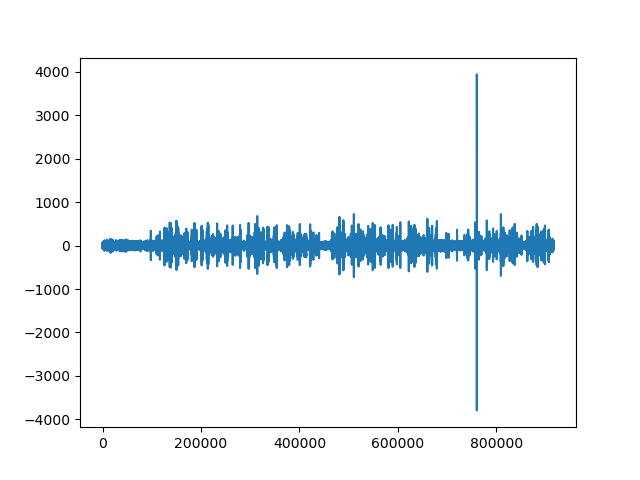

In [119]:
plt.close()
plt.plot(filt_CA1)
plt.show()

In [103]:
file_path = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/RawTracesPlotFinal_RedLinesOKsession2-RAW.eps'# Save the plot as an EMF file
plt.savefig(file_path, format='eps')

In [122]:
from scipy import signal

# Filtre parameter:
f_lowcut = 10.
f_hicut = 16.
fs = 1000
nyq = 0.5 * fs
N = 4                # Filtre order
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction

# Filtering:
b, a = signal.butter(N, Wn, 'band')
filt_PFC = signal.filtfilt(b, a, LFPtracePFC)

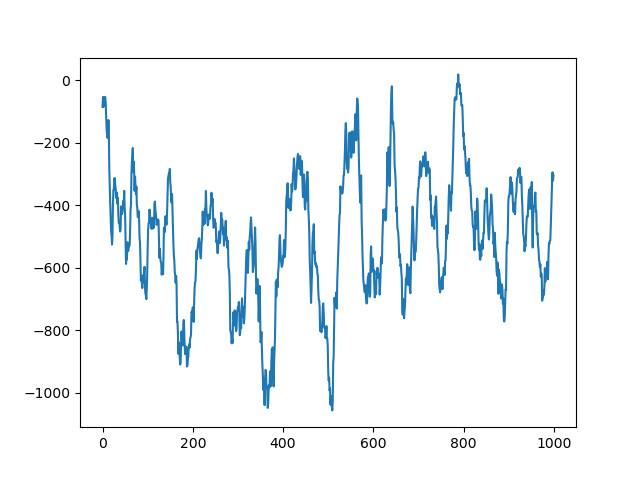

In [146]:
plt.close()
plt.plot(LFPtracePFC[147400:147400+1000])
plt.show()

In [142]:
file_path = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording/RawTracesPlotFinal_RedLinesOKsession2-SpdlPFCall.eps'# Save the plot as an EMF file
plt.savefig(file_path, format='eps')